In [1]:
from graphviz import Digraph
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
# from sklearn.linear_model import LinearRegression
# import statsmodels.api as sm
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
import copy
from random import shuffle as sl
from random import randint as rd
from IPython.display import Image

In [2]:
# 1st step: generate the directed acyclic graph
n = 20   #number of nodes
m = 20   #number of directed edges 

def gn():
    num = rd(1,1000)
    return num
def w2f(f,num,fg):
    f.write(str(num))
    if fg==True:
        f.write('\n')
    else:
        f.write(' ')

def DataMake(c):
   
    f = open('./data/data_{}_{}'.format(n,m)+"__"+str(c)+'.txt','w')
    
    node = list(range(1,n+1))
    sl(node)
    sl(node)
    
    w2f(f,n,0);w2f(f,m,1)
    edges=[]
    count=0
    while count<m:
        p1 = rd (1,n-1)
        p2 = rd (p1+1,n)
        x = node[p1-1]
        y = node[p2-1]
        if [x,y] not in edges:
            edges.append([x,y])
            w2f(f,x,0);w2f(f,y,1);
            count+=1
    print(n,' node',m,' edges')
    f.close()


In [3]:
# prepare data file for the DAG
#be careful to run this if you won't update the data you already have for c=1...100.  
# c=101
# DataMake(c)
# print('Done')

In [4]:
#2nd step: visualize the graph(which is saved in fsm.gv.pdf). return a mat describing the graph structure
def vis_mat(c,n,m):
    f = Digraph('finite_state_machine', filename='fsm.gv')
    with f.subgraph() as s:
        s.attr(rank='same')
        f.attr('node', shape='circle')
        for i in range(n):
            f.node(str(i))

    # f.attr(rankdir='LR', size='8,5')

    file1 = open('./data/data_{}_{}'.format(n,m)+"__"+str(c)+'.txt',"r")  
#     file1 = open('./data/data_10_101.txt',"r") 
    n,m=[int(x) for x in file1.readline().split()]

    f.attr('node', shape='circle')
    for i in range(n):
        f.node(str(i))

    mat=np.zeros([n]*2)
    f.attr('node', shape='circle')    
    for i in range(m):
        i,j=[int(x) for x in file1.readline().split()]
        f.edge(str(i-1), str(j-1))
        mat[j-1,i-1]=1
    #     print(i,j)

    f.view()    
    return mat

def only_mat(c,n,m):
    file1 = open('./data/data_{}_{}'.format(n,m)+"__"+str(c)+'.txt',"r")  
    n,m=[int(x) for x in file1.readline().split()]
    mat=np.zeros([n]*2)
      
    for i in range(m):
        i,j=[int(x) for x in file1.readline().split()] 
        mat[j-1,i-1]=1
    return mat


In [5]:
#run the function and see the graph structure in the fsm.gv.pdf file. The mat matrix would be used later.
c=2
mat=vis_mat(c,n,m)

In [6]:
#prepare two dicts for later use. Generate the topological order of the nodes in DAG
def structure_data(mat):
    dic=dict()  #dict(key:node, value: list of the node's chidren)
    for j in range(n):
          s=dic.setdefault(str(j),[]);
          for i in range(n):
            if mat[i,j]!=0:
                dic[str(j)].append(i)
#     print("children_dic:")
#     print(dic)

    parents_dic=dict()  #dict(key:node, value:list of the node's parents)
    for i in range(n):
          s=parents_dic.setdefault(str(i),[]);
          for j in range(n):
            if mat[i,j]!=0:
                parents_dic[str(i)].append(j)

#     print("parents_dic:")
#     print(parents_dic)

    nodes=range(n)
    #generate topological order of the nodes(note topological order is not unique to a given directed acyclic graph)
    top_list=[]

    def child(j):
        while dic[str(j)] != [] and not set(dic[str(j)]).issubset(set(top_list)):
            for i in dic[str(j)]:
                while dic[str(i)] !=[] and not set(dic[str(i)]).issubset(set(top_list)):   
                    child(i)
                else:
                    if  i not in top_list: 
                        top_list.append(i)
    #                     print("top_list=",top_list)
        else:
            if j not in top_list:
                top_list.append(j)
    #             print("top_list=",top_list)

    for j in nodes:
         child(j)

#     print('topological order of the nodes:')
#     print(top_list)
    
    
    
    N_selected=dict()
    feature_proposal=dict()
    for i in range(n):
        s0={i}
        s1=set()
        s1=set(dic[str(i)]+parents_dic[str(i)])
        s2=set()
        for j in s1:
            s2=s2.union(set(dic[str(j)]+parents_dic[str(j)]))
        s2=s2.difference(s0.union(s1))
        s3=set()
        for k in s2: 
            s3=s3.union(set(dic[str(k)]+parents_dic[str(k)]))
            
        s3=s3.difference(s1.union(s0).union(s2))
            
        N_selected[(i,1)]=len(s1)
        feature_proposal[(i,1)]=s1
        N_selected[(i,2)]=len(s2.union(s1))  
        feature_proposal[(i,2)]=s2.union(s1)
        N_selected[(i,3)]=len(s3.union(s2).union(s1)) 
        feature_proposal[(i,3)]=s3.union(s2).union(s1)
        

    return dic, parents_dic, top_list,N_selected,feature_proposal

dic, parents_dic, top_list, N_selected,feature_proposal=structure_data(mat)

def features_predict(dic,parents_dic):
    features=dict()
    for i in range(n):
        s=set(dic[str(i)]+parents_dic[str(i)]) #parents and children together
        if  len(s)==0:
            continue
        else:
            children=dic[str(i)]
            parents=parents_dic[str(i)]
            
            for j in children:      
                uncle=set(parents_dic[str(j)]).difference({i}) #kids's all parents excluding myself
                s=s.union(uncle) 
                
            for i_c in children:
                count=0
                delete_i_c=False
                for j_c in dic[str(i)]:
                    if i_c in parents_dic[str(j_c)]:
                        delete_i_c=not delete_i_c
                        count+=1
                if count!=0:
                    print("child ",i_c," has ",count," children which are also its siblings" )
                if delete_i_c:
                    s=s-{i_c}
                    
                    
            for i_p in parents:
                count=0
                delete_i_p=False
                for j_p in children:
                    if i_p in parents_dic[str(j_p)]:
                        delete_i_p=not delete_i_p
                        count+=1
                if count!=0:
                    print("child ",i_p," has ",count," children which are also its grand children" )
                if delete_i_p:
                    s=s-{i_p}
                    
        features[str(i)]=s
        
    return features                
                    
features_predicted=features_predict(dic,parents_dic)     

child  8  has  1  children which are also its grand children
child  11  has  1  children which are also its grand children
child  0  has  1  children which are also its siblings
child  11  has  2  children which are also its grand children
child  0  has  1  children which are also its siblings
child  8  has  2  children which are also its siblings


In [7]:
# for i in range(n):
#     N_selected[(i,2)]-N_selected1[(i,2)]
N_selected[(9,1)]
parents_dic[str(9)]
dic[str(9)]

1

[14]

[]

In [11]:
#3rd step: Enumerate paths:  produce all directed paths connecting two nodes V_i(node_label: start) to V_j(node_label: end).
def paths_given_two_nodes(dic,top_list, start, end):
    id_start=top_list.index(start)
    id_end=top_list.index(end)
    if id_start<=id_end:
        return []
    
    def add_path(new_node,path,paths):
        if top_list.index(new_node)>id_end:
            path.append(new_node)         
        elif top_list.index(new_node)==id_end:
            path.append(new_node)
            paths.append(copy.deepcopy(path))  #deepcopy is essential here!!
#             print('1',paths)    this print statement will produce strange result!!
            path.pop()
            return path,paths
        else:
            return path,paths
        
        for nn in dic[str(new_node)]:
            path,paths=add_path(nn,path,paths) 
        path.pop()
        return path,paths
    paths=[]
    path=[]
    path,paths=add_path(start,path,paths)
#     if paths!=[]:
#         print("the roads connecting {}th node to {}th node are:".format(start,end))
#         print(paths)
    return paths

In [12]:
#run 3rd step:
start=10;end=0
paths=paths_given_two_nodes(dic,top_list,10,0)
print(paths)

[]


In [13]:
#4th step: Generate data according to the structure of the graph:
# def generate_data(n_sample,n,parents_dic):
#     Data=np.zeros((n_sample,n))
#     mod1=lambda num:np.random.normal(0,1,num)

#     for d in range(n_sample):
#         Data[d,:]=mod1(n)  # firstly: all nodes are assigned independent random numbers with distribution N(0,1) 
#         for i in range(n):
#             for j in parents_dic[str(i)]:
#                 Data[d,i]=Data[d,i]+Data[d,j]  #for nodes with parents, the parents variables are added
#     return Data
# n_sample=1000
# Data=generate_data(n_sample,n,parents_dic)

In [14]:
#revised 4th step: Generate data according to the structure of the graph:
def generate_data_revised(n_sample,n,parents_dic,top_list):
#     np.random.seed(a=1)
    Data=np.zeros((n_sample,n))
    mod1=lambda num:np.random.normal(0,1,num)

    for d in range(n_sample):
        Data[d,:]=mod1(n)  # firstly: all nodes are assigned independent random numbers with distribution N(0,1) 
        
        tol=set(range(n))
        father=set()
        while tol!=set():
            child=set()
            for i in tol:
                if set(parents_dic[str(i)]).issubset(father):
                    child.add(i) #for each step, identify the nodes to be modified
            for i in child:
                for j in parents_dic[str(i)]:
                #the nodes modified in an order that fathers always get modified earlier than children
                #which is a group-wise topological order
                    Data[d,i]=Data[d,i]+Data[d,j]            
            father=father.union(child)  
            tol=tol-father
#             print("child=",child)
    return Data

#revised 4th step: Generate data according to the structure of the graph:
def generate_data_revised1(n_sample,n,parents_dic,top_list):
#     np.random.seed(a=1)
    Data=np.zeros((n_sample,n))
    mod1=lambda num:np.random.normal(0,1,num)

    for d in range(n_sample):
        Data[d,:]=mod1(n)  # firstly: all nodes are assigned independent random numbers with distribution N(0,1) 
        for i in reversed(top_list):
            for j in parents_dic[str(i)]:
                Data[d,i]=Data[d,i]+Data[d,j]            
    return Data

n_sample=2000
Data=generate_data_revised(n_sample,n,parents_dic,top_list)

In [15]:
#5th step: 
def feature_selection(Data, target, Num_selected,features_proposed):
    
    df=pd.DataFrame(Data)
    y=df[target]
    X = df.drop([target], axis=1)
    
    reg = LassoCV(cv=5, random_state=0).fit(X, y)
    ss1=reg.score(X, y)
#     print("Rsquare score with all features:",ss1) 

    #assign very low threshold as starting point
    clf=LassoCV(cv=5,random_state=0)
    
    sfm = SelectFromModel(clf, threshold=0.00)
    s=sfm.fit(X, y)
    X_transform = sfm.transform(X)
    n_features = X_transform.shape[1]

    # Reset the threshold till the number of features equals two.
    while n_features > Num_selected:
        sfm.threshold += 0.001
        X_transform = sfm.transform(X)
        n_features = X_transform.shape[1]
    #     print("threshold=",sfm.threshold, "n_features=",n_features)

    reg = LassoCV(cv=5, random_state=0).fit(X_transform, y)
    ss2=reg.score(X_transform, y)
#     print("Rsquare Score with selected features:",ss2) 
#     print("Num_selected=",Num_selected,"n_features=",n_features)
#     print("target=",target)
    a=list(sfm.get_support())
    a.insert(target,False)
    selected=[i for i in range(len(a)) if a[i]]
#     print("selected=",selected)
#     print("proposed=",features_proposed)
#     print("proposed_unchosen",list(set(features_proposed)-set(selected)))
#     print("chosen_unproposed",list(set(selected)-set(features_proposed)))
    return selected, ss1,ss2,df 

# print("L====================1:")    
# target=15   #n
# target=4    #y
# target=18
# # target=6

# Num_selected=N_selected[(target,1)]+2; features_proposed=feature_proposal[(target,1)]
# selected, ss1,ss2, df=feature_selection(Data, target, Num_selected,features_proposed)

# print("L====================2:")  
# Num_selected=N_selected[(target,2)]; features_proposed=feature_proposal[(target,2)]
# selected, ss1,ss2, df=feature_selection(Data, target, Num_selected,features_proposed)

# print("L====================3:")  
# Num_selected=N_selected[(target,3)]; features_proposed=feature_proposal[(target,3)]
# selected, ss1,ss2, df=feature_selection(Data, target, Num_selected,features_proposed)


In [783]:
Data=generate_data_revised(n_sample,n,parents_dic,top_list)
print("L====================1:")    

target=0
more=0
# target=6


Num_selected=N_selected[(target,1)]+more; features_proposed=feature_proposal[(target,1)]
selected, ss1,ss2, df=feature_selection(Data, target, Num_selected,features_proposed)

print("features_predicted",features_predicted[str(target)])

L====================1:
Rsquare score with all features: 0.947718900248335
Rsquare Score with selected features: 0.9475932651446881
Num_selected= 3 n_features= 3
target= 0
selected= [5, 17, 19]
proposed= {8, 17, 11}
proposed_unchosen [8, 11]
chosen_unproposed [19, 5]
features_predicted {17, 19, 5}


### 2. Some nice examples of feature selection with magic value(?) of N_selected(see DAG2.png below):  
  - for target=1, selected [0, 4, 6, 10, 11, 19], $R^2\approx0.92$.
    Rule: If father is also the target's one child's father, delete it. 16 is aslo 4'th father.  So it is deleted despite it's direct father of 1.
    
  - for target=5, selected [0, 1, 4, 6, 10, 11, 19], $R^2\approx0.97$.
    Rule: If father is also the target's one child's father, delete it. 16 is aslo 4'th father.  So it is deleted despite it's direct father of 5.
    

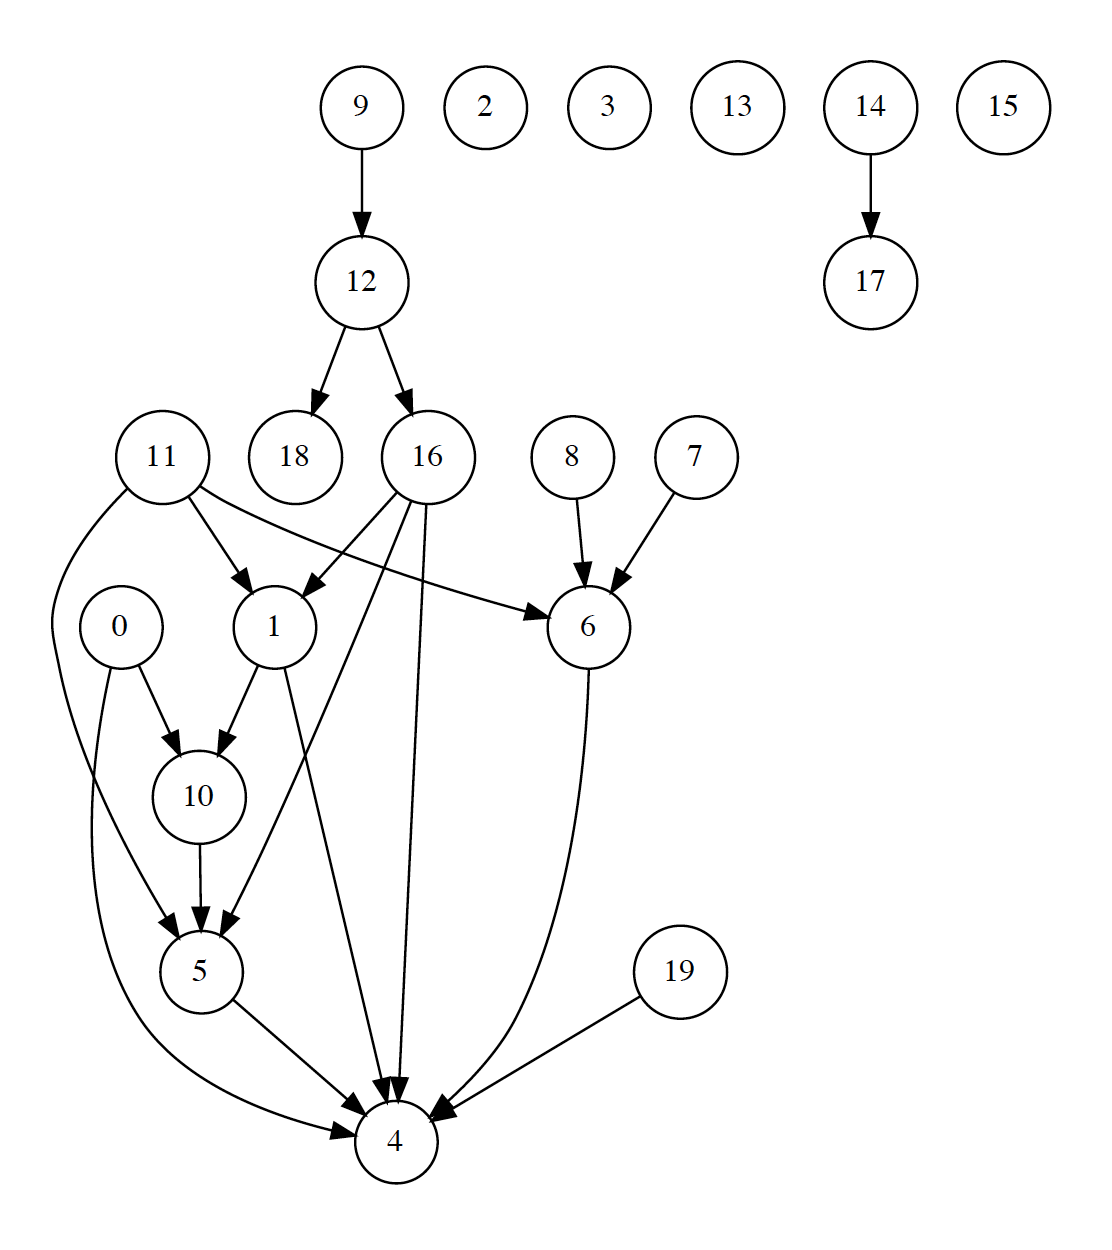

In [744]:
# df.corr();
fig = Image(filename=('./DAG3.png'))
fig

### 2. Some nice examples of feature selection with magic value(?) of N_selected(see DAG2.png below):  
  
  - for target=4,  the selected nodes are: [2,10], $R^2\approx0.66$(L=1)
  - for target=7,  the selected nodes are: [14,16], $R^2\approx0.66$ (L=1)
  - for target=2,   the selected nodes are: [3, 4, 5, 10], $R^2\approx0.66$(L=1 Plus half of L=2)
  - for target=10,  the selected nodes are: [2,4], $R^2\approx0.5$ (L=1 Plus  L=2)
  - for target=14,  the selected nodes are: [7,9], $R^2\approx0.76$(L=1)
  - for target=11,  the selected nodes are: [1, 5, 6, 8, 12, 17, 19](more =2), $R^2\approx0.89$    ( proposed:[0, 1, 6, 8, 17], but somehow the code hate 0 very much!!)(L=1PlusL=2-{0})
  - for target=0, the selected nodes are: [5, 17, 19] with $R^2\approx0.95$  (proposed [8, 17, 11]), somehow the code hate to choose 8 and 11 which are rearest neigbor! And prefer next nearest neighbor 5,19!)
  
  
  - for target=8,the selected nodes are: [5, 11, 17, 19](more=1) with $R^2\approx0.88$ (the code hate 0 and vise versa!)
  
  - for target=17, the selected nodes are: [0, 5, 8, 11, 19](more=0), all neibours are chosen!

  - for target=19, the selected nodes are:[0, 1, 5, 8, 11, 12, 17](more=5),(chosen_unproposed [0, 5, 8, 11, 12]) (L=1plusL=2)
  - for target=6, the selected nodes are:[11](more=0),$R^2\approx0.5$(L=1) 
  - for target=9, the selected nodes are:[14](more=0),$R^2\approx0.68$(L=1) 
  - for target=16, the selected nodes are:[7](more=0),$R^2\approx0.48$(L=1) 
  

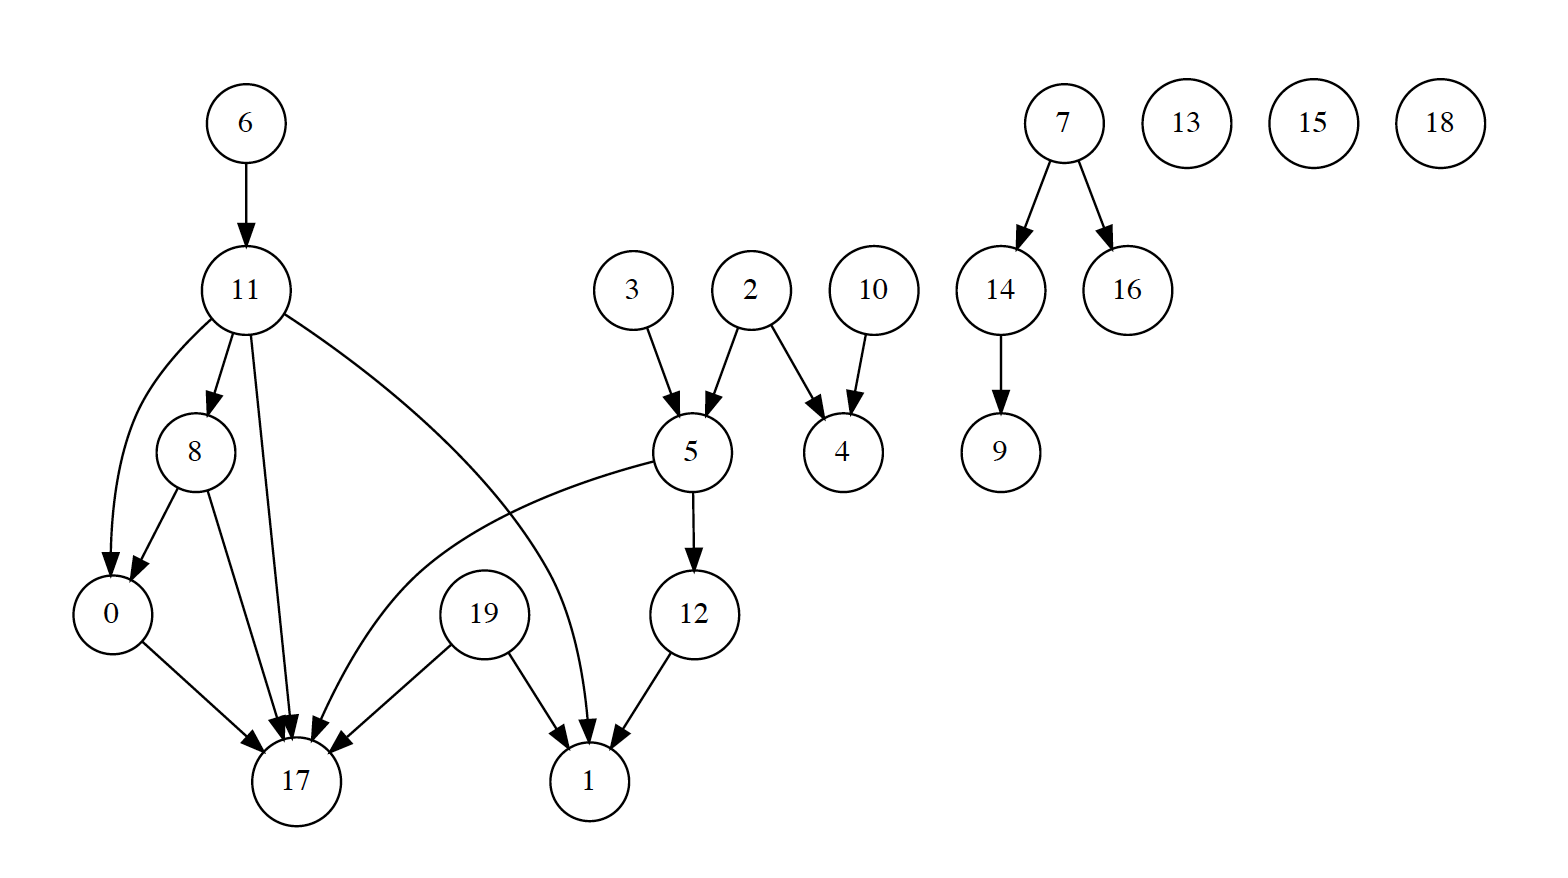

In [509]:
# df.corr();
fig = Image(filename=('./DAG2.png'))
fig

### 1. Some nice examples of feature selection with magic value(?) of N_selected(see DAG1.png below):  
  - for target=18,  the selected nodes are: [0, 5, 6, 7, 11, 12], $R^2=0.89$(proposed [0, 11, 12, 5], but 6,7 adds to 12)
  - for target=12,  the selected nodes are: [6, 7, 18], $R^2=0.83$ 
  - for target=9,   the selected nodes are: [0, 7, 8, 19], $R^2\approx0.50$
  - for target=19,  the selected nodes are: [0, 7, 8, 19], $R^2\approx0.87$
  - for target=14,  the selected nodes are: [3,5], $R^2\approx0.91$
  - for target=10,  the selected nodes are: [3, 8, 15], $R^2\approx0.50$    (proposed:[17, 3, 15], but somehow the code hate 17 very much!!)
  - for target=17,the selected nodes are: [2, 3, 8, 15] with $R^2\approx0.75$ (why the code hate 10 so so much?)
  - for target=15, the selected nodes are: [10, 16, 17]
  - for target=0, the selected nodes are: [1, 7, 8, 9, 18, 19] with $R^2\approx0.92$  (why not [5,11] instead of [7,8, 9]? Maybe we can argue 19 is fully described by 7,8,9. But 18 is also fully described by 5,11. Although 18 influence 12, but that has no effect on 0??.  Or, maybe that's just because #3>#2?  HAHA!  Absolutely not! There is a golden principle!)
### Question: why 10 and 17 hate each other  so mcuh? 

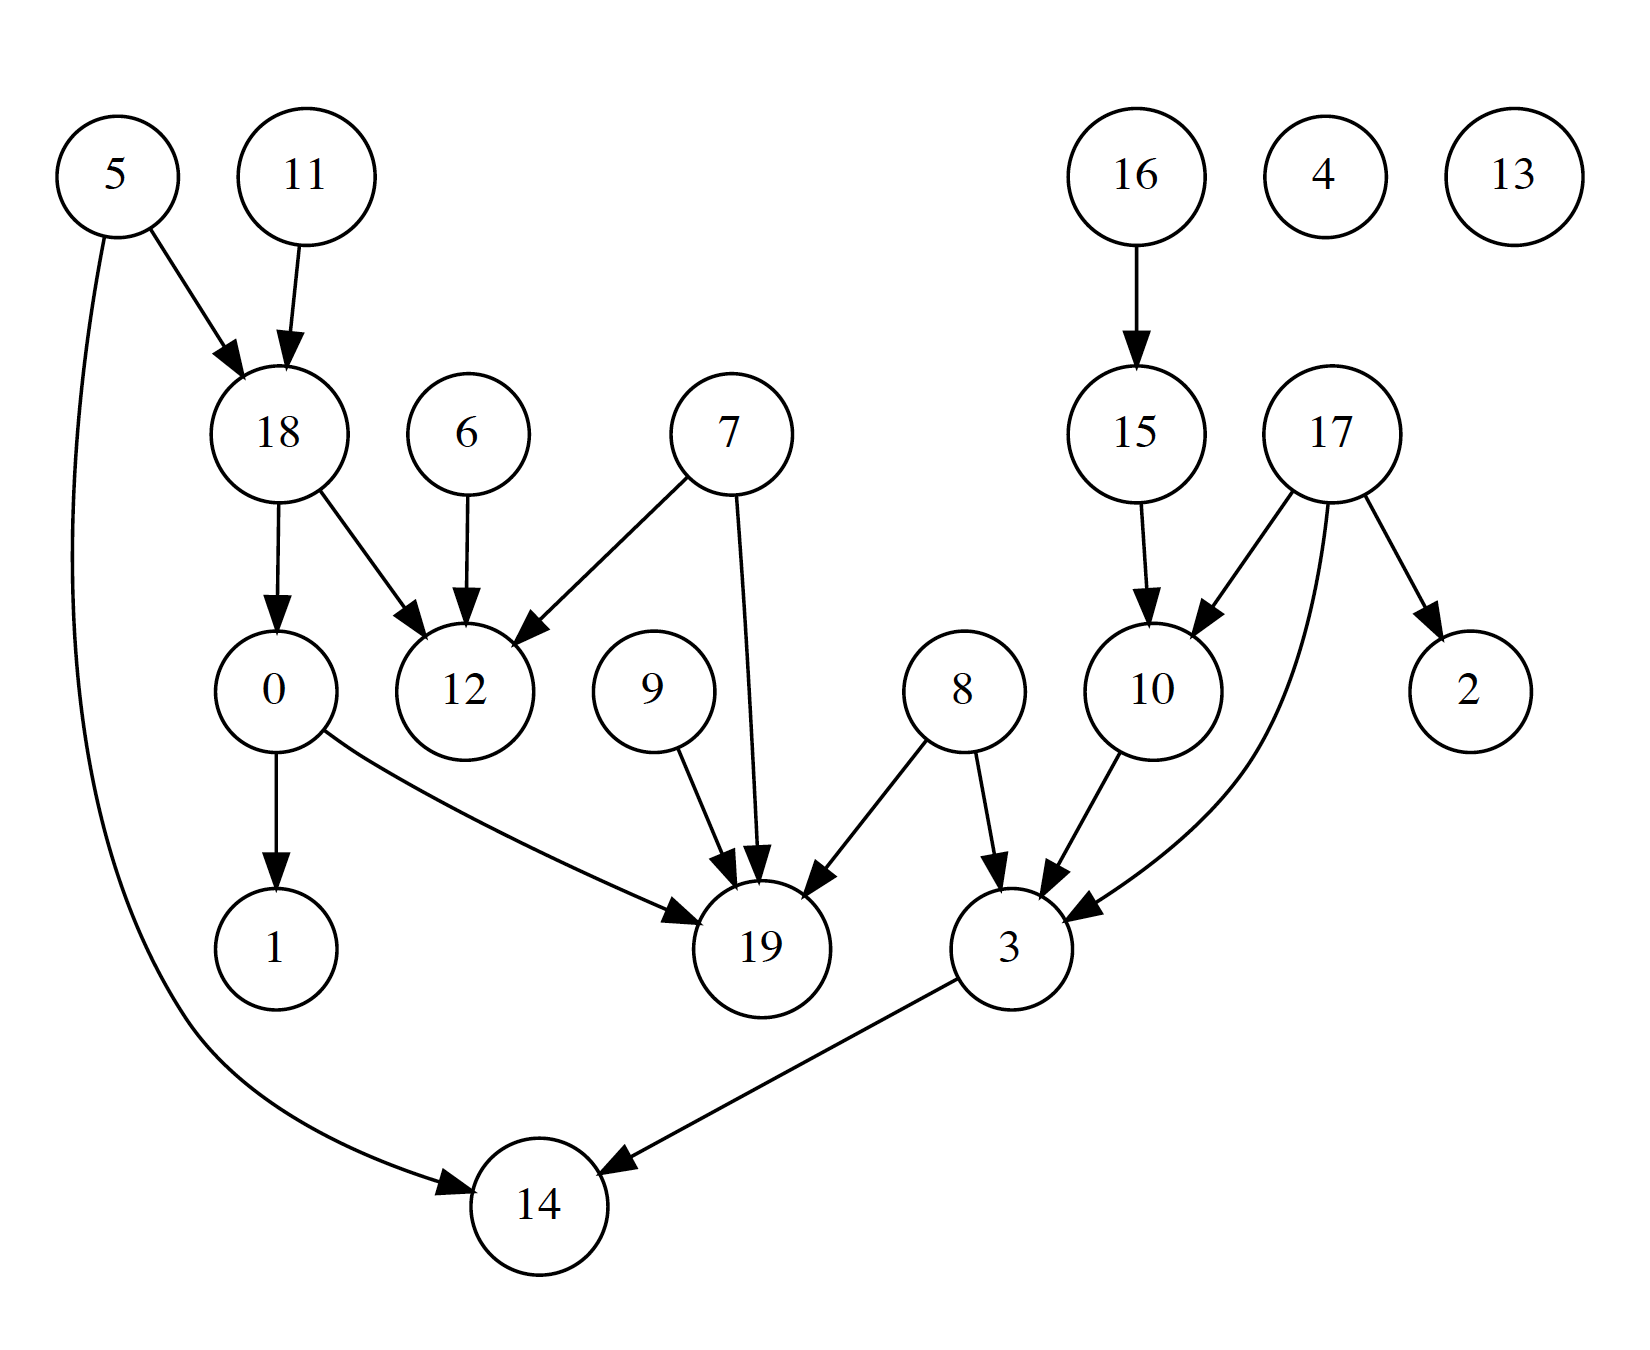

In [289]:
# df.corr();
fig = Image(filename=('./DAG1.png'))
fig

# Golden Rule to select features:
- Based on the calculated stable features for many targets in the three graphs above, we predict the rules for feature selection given a target:
  - 1. Collect all direct parents and children for the target, call it S1
  - 2. For all the children, combine all their parents into a collection(except target itself), call it S2 
  - 3. Get rid of those elements in S1 that have odd number of children in the children set of target.  
  - 4. Combine the remaining set in 3 with S2.
  
- The rule has been implemented in the function features_predict(dic,parents_dic) and was sucessfully tested in 100 random DAGs(all sites except those isolated ones).

## 6th step. 
- Now, let's generate 100 random graphs with n=20 nodes and m=20 edges. Then, calculate $R^2$ score for predicted features according to the rule summed above. 

In [806]:
#run the function and see the graph structure in the fsm.gv.pdf file. The mat matrix would be used later.

result=[]
for c in range(100):
#DataMake(c) #very important note: we already have graph data for c in range(100), run this line will 
#update the graph structure. The new structure will not corresponds to the graphs shown in the notebook
#as well as the descriptions above each graph

    #mat=vis_mat(c,n,m)
    mat=only_mat(c,n,m)
    dic, parents_dic, top_list, N_selected,feature_proposal=structure_data(mat)                    
    features_predicted=features_predict(dic,parents_dic) 


    Data=generate_data_revised(n_sample,n,parents_dic,top_list)
    print("c=",c)
#     print("L====================1:")    

    for target in range(n):
        if str(target) in features_predicted:

            Num_selected=len(features_predicted[str(target)]); 

            selected, ss1,ss2, df=feature_selection(Data, target, Num_selected,features_proposed)
            result.append((c,target,selected,len(selected),ss1,ss2))
            
    #         print("features_predicted",features_predicted[str(target)])
            if set(selected)!=features_predicted[str(target)]:
                print("target target  =",target, "   ","feature predicted  wrong!" )



child  15  has  1  children which are also its grand children
child  16  has  1  children which are also its grand children
child  3  has  1  children which are also its siblings
child  3  has  1  children which are also its siblings
c= 0
child  17  has  1  children which are also its grand children
child  10  has  1  children which are also its siblings
c= 1
child  8  has  1  children which are also its grand children
child  11  has  1  children which are also its grand children
child  0  has  1  children which are also its siblings
child  11  has  2  children which are also its grand children
child  0  has  1  children which are also its siblings
child  8  has  2  children which are also its siblings
c= 2
c= 3
child  16  has  1  children which are also its grand children
child  16  has  1  children which are also its grand children
child  1  has  1  children which are also its siblings
child  5  has  1  children which are also its siblings
c= 4
child  16  has  1  children which are a

child  14  has  1  children which are also its siblings
child  5  has  1  children which are also its grand children
child  15  has  1  children which are also its grand children
child  1  has  1  children which are also its siblings
child  0  has  1  children which are also its grand children
child  2  has  1  children which are also its siblings
c= 40
child  18  has  1  children which are also its grand children
child  16  has  1  children which are also its siblings
c= 41
child  9  has  1  children which are also its grand children
child  6  has  1  children which are also its siblings
child  11  has  1  children which are also its grand children
child  10  has  1  children which are also its siblings
c= 42
child  8  has  1  children which are also its grand children
child  8  has  1  children which are also its grand children
child  6  has  1  children which are also its siblings
child  7  has  1  children which are also its siblings
c= 43
child  14  has  1  children which are also

c= 87
child  6  has  1  children which are also its siblings
child  4  has  2  children which are also its grand children
child  3  has  2  children which are also its siblings
child  6  has  1  children which are also its siblings
child  3  has  1  children which are also its grand children
child  4  has  1  children which are also its grand children
c= 88
child  14  has  2  children which are also its siblings
child  0  has  2  children which are also its grand children
c= 89
child  14  has  1  children which are also its siblings
child  6  has  1  children which are also its grand children
child  16  has  1  children which are also its siblings
child  15  has  1  children which are also its grand children
c= 90
c= 91
child  15  has  1  children which are also its grand children
child  9  has  1  children which are also its grand children
child  5  has  1  children which are also its siblings
child  2  has  1  children which are also its siblings
c= 92
child  18  has  1  children whi

### Data analysis for step 6
- Let's do some data analysis based on the the calculated results. 

In [808]:
result
# c,target,selected,len(selected),ss1,ss2

1725

In [384]:

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

axs[0].hist(result[], bins=n_bins)
axs[1].hist(y, bins=n_bins)

(0, 3, [6, 12, 14], 3, 1, 0.8340858170084281, 0.7651641164825633)

In [820]:
ss1_1=np.array([res[4] for res in result if res[3]==1])
ss1_2=np.array([res[4] for res in result if res[3]==2])
ss1_3=np.array([res[4] for res in result if res[3]==3])
ss1_4=np.array([res[4] for res in result if res[3]==4])
ss1_5=np.array([res[4] for res in result if res[3]==5])
ss1_6=np.array([res[4] for res in result if res[3]==6])
ss1_7=np.array([res[4] for res in result if res[3]==7])
ss1_8=np.array([res[4] for res in result if res[3]==8])
ss1_L=np.array([len(ss1_1),len(ss1_2),len(ss1_3),len(ss1_4),len(ss1_5),len(ss1_6),len(ss1_7),len(ss1_8)])
ss1_M=np.array([ss1_1.mean(),ss1_2.mean(),ss1_3.mean(),ss1_4.mean(),ss1_5.mean(),ss1_6.mean(),ss1_7.mean(),ss1_8.mean()])
ss1_V=np.array([ss1_1.var(),ss1_2.var(),ss1_3.var(),ss1_4.var(),ss1_5.var(),ss1_6.var(),ss1_7.var(),ss1_8.var()])

ss2_1=np.array([res[5] for res in result if res[3]==1])
ss2_2=np.array([res[5] for res in result if res[3]==2])
ss2_3=np.array([res[5] for res in result if res[3]==3])
ss2_4=np.array([res[5] for res in result if res[3]==4])
ss2_5=np.array([res[5] for res in result if res[3]==5])
ss2_6=np.array([res[5] for res in result if res[3]==6])
ss2_7=np.array([res[5] for res in result if res[3]==7])
ss2_8=np.array([res[5] for res in result if res[3]==8])
ss2_L=np.array([len(ss2_1),len(ss2_2),len(ss2_3),len(ss2_4),len(ss2_5),len(ss2_6),len(ss2_7),len(ss2_8)])
ss2_M=np.array([ss2_1.mean(),ss2_2.mean(),ss2_3.mean(),ss2_4.mean(),ss2_5.mean(),ss2_6.mean(),ss2_7.mean(),ss2_8.mean()])
ss2_V=np.array([ss2_1.var(),ss2_2.var(),ss2_3.var(),ss2_4.var(),ss2_5.var(),ss2_6.var(),ss2_7.var(),ss2_8.var()])


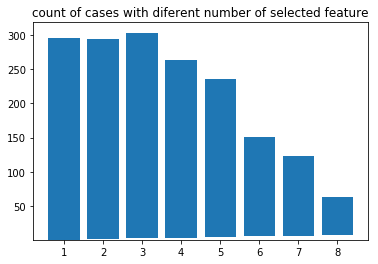

In [833]:
import matplotlib.pyplot as plt
%matplotlib inline
s=plt.bar(range(1,9), ss1_L, width=0.8, bottom=range(1,9), align='center', data=None)
s=plt.title("count of cases with diferent number of selected feature")
# plt.errorbar(range(1,9), ss1_M, ss1_V)

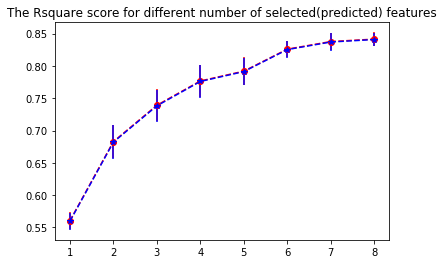

In [830]:
fig, ax = plt.subplots()
s=ax.errorbar(range(1,9), ss1_M, ss1_V,marker="o",color='r',ls='dashed')
s=ax.errorbar(range(1,9), ss2_M, ss2_V,marker="*",color='b',ls='dashed')
s=ax.set_title("The Rsquare score for different number of selected(predicted) features"); 


## Summary  and discussion
####  Step 1
- The directed acyclic graphs is built by function DataMake(c). The node pairs for directed edges are saved in a datafile. 

#### step 2
- The structure is visualized by function vis_mat(c,n,m) in a generated pdf file. In vis_mat, a matrix is also generated to describe the graph. One can also choose to run only_mat(c,n,m) which skips the step for pdf figure generation and prompt viewing. 


- Two structual dictionaries(dic for recording children and parent_dic for recording parents) are generated in function structure_data(mat) for convenience of later use. A topological order of the nodes top_list is also generated in the same function. 

#### step 3
- All paths are found and listed by the function paths_given_two_nodes(dic,top_list, start, end). Top_list is used to speed up the procedure of finding all paths from "start" node to "end" node.

#### step 4
- The functions generate_data_revised(n_sample,n,parents_dic,top_list) and generate_data_revised1(n_sample,n,parents_dic,top_list) are equivalent functions to generate a random dataset required for later use. In generate_data_revised1, we used Top_list and the data generation process is straitforwad. In generate_data_revised, we defined a "group topological order"  which might be useful somewhere else. 

#### step 5
 - The most intersting thing to me in this project is to find the golden rules to generate "robust" features for general DAG. These rules are described in text and was implemented in the function feature_selection(Data, target, Num_selected,features_proposed). The rule is so robust that it passed test for thousands of chosen targets in 100 graphs. I guess there might be some rigorous mathematics that protects these rules. 
 
 - Technicaly, what we did is to pick an arbitrary target, and use sklearn.feature_selection.SelectFromModel combined with sklearn.linear_model.LassoCV to select the most important nodes (features) surrounding the target node. LassoCV is to use Cross validation(we used cv=5) in the linear regression with L1 regularization(nice to select features).  We choose to focus on the R^2 score which is a good measure of overall fitting of linear regression. Persoanly I think R^2 is especially meaningful in the current peoject. Given a graph, for different random realization of dataset, usually the code will give us different set of selected features. However, we noticed that there is some "magic" sets that are robust to randomness of the dataset. Moreover, these sets are so good in representing the whole graph except the target itself that their R^2 is very close to the model including all features.  

- To find the rules, we studied some graphs in details. Two most studied graphs are DAG2.png and DAG1.png with many observations presented right above each graph.  

#### step 6
- For step 6, we generated 100 random graphs and picked all possible nodes as targets. The most important information we get is in the last figure. That the more features selected, the larger R^2 would become. 

- This result seems in aligenment with general idea in linear digression problem. To model the problem better with linear regression, it's always not bad to add more features. At worst case, we can set extra coefficients to be zero and the result remain the same. However, it seems to me, our problem is not a typical linear regression in that, every nodes are similarly random , while in the typical linear regression, the Gaussion randomness is only assigned to the target. 

-  Besides the number of elements, the sets of selected features can be classified in different ways. For eample, like atomic shell, some are described by complete shells(each shell is composed of parents shell and children shell), some are not so complete. The completeness may has some consequence to R^2.

#### discussion
- It seems to me, this graph problem is some extended version, or statistical version of linear algebra(a set of linear equations) problem. In such version, we are not only interested in the normal solutions(maybe called average solutions here), but also the correlation between different variables, as well as the transfer of randomness of some variable to others... One thing interets me now, is that can we derive the rules from rigrous math point of view? 